# Initialize Spark in Jupyter Notebook

In [7]:
#Manually helping findspark locate Python folder
import os

os.environ["SPARK_HOME"] = "C:/spark-4.0.1-bin-hadoop3"
os.environ["PYSPARK_PYTHON"] = "python"
os.environ["PYSPARK_DRIVER_PYTHON"] = "python"


In [8]:
#Importing findspark to allow Jupyter Notebook to locate the local Spark installation.
import findspark
findspark.init()  # connects Jupyter to Spark installation


In [11]:
from pyspark.sql import SparkSession ## Import SparkSession the main entry point for Spark SQL.
 #Create a Spark session with an project name.
spark = SparkSession.builder \
    .appName("YouTubeTrendingProject") \
    .getOrCreate()

spark


# Loading  Dataset

In [12]:
#Load the YouTube Trending dataset in CSV format.
df = spark.read \
    .option("header", True) \
    .option("inferSchema", True) \
    .option("multiLine", True) \
    .option("escape", "\"") \
    .option("quote", "\"") \
    .option("ignoreLeadingWhiteSpace", True) \
    .option("ignoreTrailingWhiteSpace", True) \
    .csv(r"C:\Users\Sakshi\Documents\CloudProject\Data\trending_yt_videos_113_countries.csv")


# Data Cleaning

In [14]:
from pyspark.sql.functions import col, to_timestamp, coalesce, lit
# Drop rows where essential fields are missing.
df = df.dropna(subset=["video_id", "country", "publish_date", "snapshot_date"])
#Convert date columns into proper Timestamp format.
df = df.withColumn("publish_date", to_timestamp("publish_date"))
df = df.withColumn("snapshot_date", to_timestamp("snapshot_date"))
#Convert and clean numeric columns.
df = df.withColumn("view_count", col("view_count").cast("long"))
df = df.withColumn("like_count", coalesce(col("like_count"), lit(0)))
df = df.withColumn("comment_count", coalesce(col("comment_count"), lit(0)))

df.show(10)


+--------------------+----------------+----------+--------------+---------------+-------------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------+-------------------+--------+
|               title|    channel_name|daily_rank|daily_movement|weekly_movement|      snapshot_date|country|view_count|like_count|comment_count|         description|       thumbnail_url|   video_id|          channel_id|          video_tags|         kind|       publish_date|langauge|
+--------------------+----------------+----------+--------------+---------------+-------------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+--------------------+-------------+-------------------+--------+
|Bling4 - PaHarare...|          Bling4|         1|             0|             49|2025-11-18 00:00:00|     ZW|    211062|     12468|         1489|

In [7]:
from pyspark.sql.functions import try_to_timestamp

df = df.withColumn("publish_date", try_to_timestamp("publish_date"))
df = df.withColumn("snapshot_date", try_to_timestamp("snapshot_date"))


In [8]:
df = df.dropna(subset=["publish_date", "snapshot_date"])


In [10]:
from pyspark.sql.window import Window
from pyspark.sql.functions import dense_rank, desc

w = Window.partitionBy("country", "snapshot_date").orderBy(desc("view_count"))

df = df.withColumn("daily_rank", dense_rank().over(w))
df.show(5)


+--------------------+-----------------+----------+--------------+---------------+-------------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+------------------------+-------------+-------------------+--------+
|               title|     channel_name|daily_rank|daily_movement|weekly_movement|      snapshot_date|country|view_count|like_count|comment_count|         description|       thumbnail_url|   video_id|          channel_id|              video_tags|         kind|       publish_date|langauge|
+--------------------+-----------------+----------+--------------+---------------+-------------------+-------+----------+----------+-------------+--------------------+--------------------+-----------+--------------------+------------------------+-------------+-------------------+--------+
|$1 vs $10,000,000...|          MrBeast|         1|           -18|             15|2023-12-01 00:00:00|     AE|  81880212|   327984

In [15]:
from pyspark.sql.functions import avg, countDistinct, col, when
#Create engagement_rate column manually
df = df.withColumn(
    "engagement_rate",
    when(col("view_count") > 0,
         (col("like_count") + col("comment_count")) / col("view_count"))
    .otherwise(0)
)

#Now aggregate
final_stats = df.groupBy("country") \
    .agg(
        countDistinct("video_id").alias("unique_videos"),
        avg("view_count").alias("avg_views"),
        avg("engagement_rate").alias("avg_engagement_rate")
    )

final_stats.show(50, truncate=False)


+-------+-------------+--------------------+--------------------+
|country|unique_videos|avg_views           |avg_engagement_rate |
+-------+-------------+--------------------+--------------------+
|DZ     |12736        |1584422.6470181963  |0.05897843752469904 |
|LT     |5507         |1.9266423049152E7   |0.033618194214339175|
|FI     |5076         |1.6285367087989792E7|0.04450123442149585 |
|AZ     |5756         |1.5435060275342284E7|0.02640671510661326 |
|UA     |7391         |7872477.076001169   |0.0408739653176015  |
|RO     |5680         |1.4291444637011433E7|0.0326599139022576  |
|LA     |4966         |2.2492455187843982E7|0.022908056830284407|
|NL     |6660         |1.306471731028892E7 |0.039010885187081165|
|MN     |5467         |2.1961886529163122E7|0.029245906308452686|
|PL     |9276         |6413352.9277345305  |0.04648166661045309 |
|AM     |5455         |1.870986512298655E7 |0.025195141315068857|
|MK     |5684         |1.8570535976559587E7|0.02364402147660213 |
|MX     |1

In [14]:
# Save country-level stats
final_stats.write \
    .option("header", True) \
    .mode("overwrite") \
    .csv("C:/Users/Sakshi/Documents/CloudProject/output/country_stats_csv")





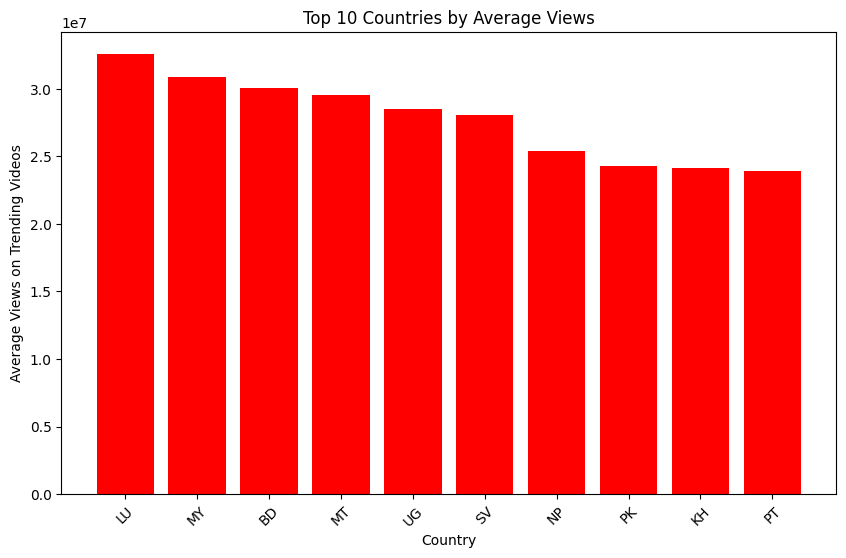

In [27]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("C:/Users/Sakshi/Documents/CloudProject/output/country_stats_csv/cleaned_dataset.csv")  
top_views = df.sort_values("avg_views", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_views["country"], top_views["avg_views"], color="red")
plt.xlabel("Country")
plt.ylabel("Average Views on Trending Videos")
plt.colour="red"
plt.title("Top 10 Countries by Average Views")
plt.xticks(rotation=45)
plt.show()



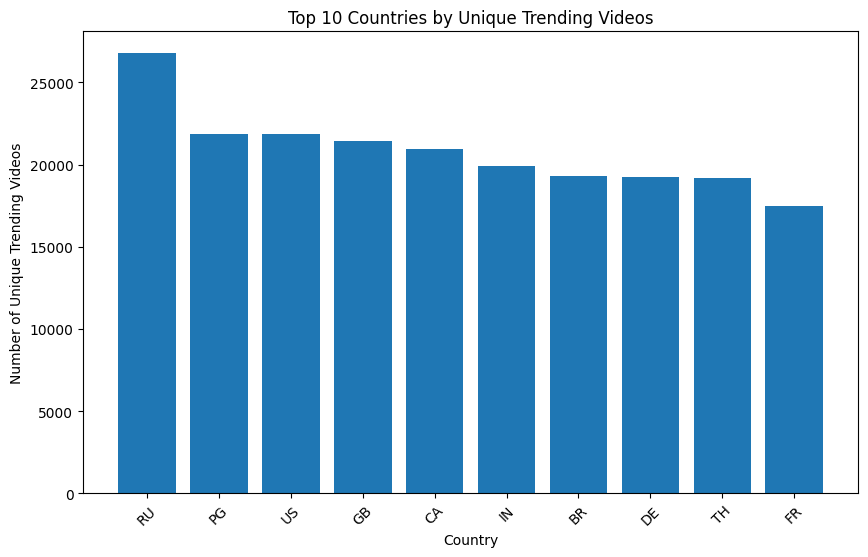

In [21]:
import matplotlib.pyplot as plt

top_videos = df.sort_values("unique_videos", ascending=False).head(10)

plt.figure(figsize=(10,6))
plt.bar(top_videos["country"], top_videos["unique_videos"])
plt.xlabel("Country")
plt.ylabel("Number of Unique Trending Videos")
plt.title("Top 10 Countries by Unique Trending Videos")
plt.xticks(rotation=45)
plt.show()

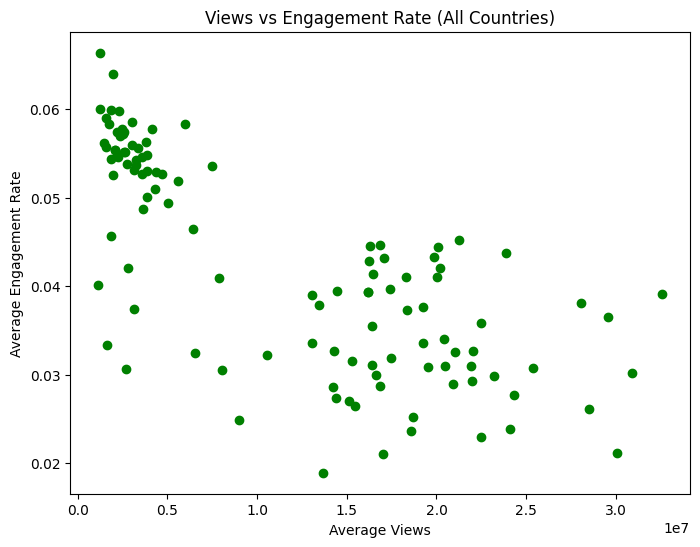

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(df["avg_views"], df["avg_engagement_rate"], color="Green")
plt.xlabel("Average Views")
plt.ylabel("Average Engagement Rate")
plt.title("Views vs Engagement Rate (All Countries)")
plt.show()